In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0) / 1024**3, 1), 'GB')

Using device: cpu


In [3]:
### import data
import pickle
for dataset in ['biofam','flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1' # biofam seemed to have an encoding issue which this fixes
        a = u.load()
    X=a[0].astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    
def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        a = u.load()
    X=a[0]
    X=X.astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    d = X.max()+1
    return X, d

def train_models(
        models, batchsize=20, max_epochs=50, 
        batched=False, clamp_at=None, 
        optimizer=torch.optim.Adadelta, **optim_kwargs):
    print(f"dataset: {dataset}")
    models_loss_values={}
    for model in models:
        loss_values = model.train(
            batchsize=batchsize, max_epochs=max_epochs, tqdm=tqdm, plot=False,
            clamp_at=clamp_at, batched=batched,
            optimizer=optimizer, **optim_kwargs)
        plt.plot(loss_values, label=model.name)
        plt.ylabel('avg loss (NLL)')
        plt.xlabel('Epoch')
        plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optimizer.__module__} {optim_kwargs}")
        models_loss_values[f"{model.name}"]=loss_values
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    return models_loss_values

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
╭──flare
│ data shape:(1065, 13)
│ range of X values: 0 -- 7
╰───────────────────
╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────


In [6]:
### initialize models
dataset = 'lymphography'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps      = PosMPS(X, d, D, homogeneous=False, w_randomization=wr)
mps_hom  = PosMPS(X, d, D, homogeneous=True, w_randomization=wr)
mps_s    = PosMPS(X, d, D, homogeneous=False, log_stability=True, w_randomization=wr)
mps_s_hom= PosMPS(X, d, D, homogeneous=True, log_stability=True, w_randomization=wr)
rBorn      = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False, w_randomization=wr) 
rBorn_hom  = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False, w_randomization=wr)
rBorn_s    = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True, w_randomization=wr)
rBorn_s_hom= Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True, w_randomization=wr)
cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False, w_randomization=wr)
cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False, w_randomization=wr)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True, w_randomization=wr)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True, w_randomization=wr)
models     = (
    # rBorn, cBorn, mps, 
    rBorn_s, cBorn_s, mps_s)
models_hom = (
    # rBorn_hom, cBorn_hom, mps_hom, 
    rBorn_s_hom, cBorn_s_hom, mps_s_hom)

def clip_grad(grad, clip_val, param_name, verbose=False):
    """Clip the gradients, to be used as a hook during training."""
    if torch.isnan(grad).any():
        print(f"├─NaN value in gradient of {param_name}, {grad.size()}")
    if grad.dtype==torch.cfloat:
        for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} real {ext} {v:.2} to size {clip_val})")
        for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} imag {ext} {1.j*v:.2} to size {clip_val})")
        clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
                                     grad.imag.clamp(-clip_val, clip_val))
    else:
        for ext, v in [("min", grad.min()),("max", grad.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} {ext} {v:.2} to size {clip_val})")
        clipped_grad = torch.clamp(grad, -clip_val, clip_val)
    return clipped_grad

print(f"Models: D={D}, d={d}")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for param_index, p in enumerate(model.parameters()):
        pnames = list(model.state_dict().keys())
        p.register_hook(lambda grad: clip_grad(grad, 1000, pnames[param_index], verbose=True))
        if torch.isnan(p).any():
            print(f"{pnames[param_index]} contains a NaN value!")

╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
Models: D=8, d=8
	torch.Size([19, 8, 8, 8]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([19, 8, 8, 8]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([19, 8, 8, 8]) model type: Positive MPS, Non-homogeneous + log_stability
	torch.Size([8, 8, 8]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([8, 8, 8]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([8, 8, 8]) model type: Positive MPS, Homogeneous + log_stability


dataset: lymphography
╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability, on cpu
│         batchsize:20, torch.optim.adadelta, {'lr': 0.001}.



│ loss values: 40.219 40.171 40.133 40.105 40.090 40.051 40.013 39.967 39.940 39.911
│ Finished training.
╰───────────────────────────

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous + log_stability, on cpu
│         batchsize:20, torch.optim.adadelta, {'lr': 0.001}.



│ loss values: 40.437 40.403 40.388 40.338 40.308 40.263 40.246 40.204 40.167 40.135
│ Finished training.
╰───────────────────────────



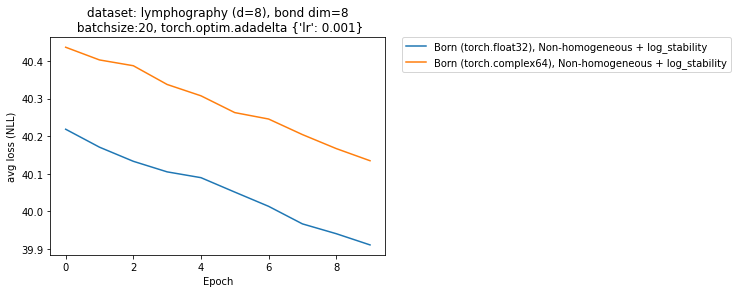

In [5]:
lossvals = train_models(
    [rBorn_s, cBorn_s,rBorn_s_hom, cBorn_s_hom],
    clamp_at=1000, batchsize=10, max_epochs=1000, batched=True, optimizer=torch.optim.Adam, lr=0.001)

In [ ]:
lossvals = train_models(
    [rBorn_s, cBorn_s,rBorn_s_hom, cBorn_s_hom],
    clamp_at=1000, batchsize=10, max_epochs=19000, batched=True, optimizer=torch.optim.Adam, lr=0.001)

In [ ]:
lossvals = train_models(models_hom, batchsize=10, max_epochs=1000, optimizer=torch.optim.Adadelta)

In [ ]:
lossvals = train_models([mps, mps_hom, mps_s, mps_s_hom], batchsize=10, max_epochs=10)

## Useful things?

In [ ]:
# Testing item selection

d=6
bs=3
slen=5
D=2

X = torch.randint(d,(bs,slen))
print(X)
weights = torch.arange(bs*slen*d*D*D).view(bs,slen,d,D,D)#.type(torch.cfloat)
# print(weights)
# what we want to do is, 
# in the bth batch and the ith core, 
# choose the X[b,i]th weight element
print("Selected weight items:")
for b, _ in enumerate(weights):
    for i, _ in enumerate(weights[b]):
        print(weights[b,i,X[b,i]])
    print()

# using a one-hot encoding of X, a tensor Xh of shape [bs,slen,d]
Xh = torch.nn.functional.one_hot(X, num_classes=d)
print("weights' shape", weights.shape)
print("1hot obs shape", Xh.shape)
# for b,_ in enumerate(ww):
#     print((ww[b] * XXh[b][:, :,None,None]).sum(1))
selected = (weights * Xh[:, :, :, None, None]).sum(2)
print("Selected weight items:")
print(selected.shape)
print(selected)

In [ ]:
# # torch.autograd.set_detect_anomaly(True)
# def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
#     trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
#     optimizer = torch.optim.Adadelta(self.parameters(), **optim_kwargs)
#     early_stopping_threshold = 1e-6 # min difference in epoch loss 
#     loss_values = [] # store by-epoch avg loss values
#     print(f'╭───────────────────────────\n│Training {self.name},')
#     print(f'│         batchsize:{batchsize}, {optimizer.__module__}, {optim_kwargs}.')
#     av_batch_loss_running = -1e4
#     with tqdm(range(max_epochs), unit="epoch", leave=True) as tepochs:
#         for epoch in tepochs:
#             batch_loss_list = []
#             with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
#                 for batch in tepoch:
#                     for pindex, p in enumerate(self.parameters()):
#                         if torch.isnan(p).any():
#                             pnames = list(self.state_dict().keys())
#                             print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                             print(f"└────Stopped before epoch {epoch}. NaN in weights {pnames[pindex]}!")
#                             if plot:
#                                 plt.plot(loss_values)
#                                 plt.show()
#                             return loss_values
#                     self.zero_grad()
#                     neglogprob = 0
#                     for x in batch:
#                         out = self(x)
#                         neglogprob -= out
#                     loss = neglogprob / len(batch)
#                     loss.backward()
#                     # for pindex, p in enumerate(self.parameters()):
#                     #     if torch.isnan(p.grad).any():
#                     #         pnames = list(self.state_dict().keys())
#                     #         print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                     #         print(f"└────Stopped. NaN value in gradient for {pnames[pindex]}!")
#                     #         if plot:
#                     #             plt.plot(loss_values)
#                     #             plt.show()
#                     #         return loss_values
#                     optimizer.step()
#                     tepoch.set_postfix(loss=loss.item())
#                     batch_loss_list.append(loss.item())
#                 av_batch_loss = torch.Tensor(batch_loss_list).mean().item()
#                 loss_values.append(av_batch_loss)
#                 tepochs.set_postfix(av_batch_loss=av_batch_loss)
#                 if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
#                     print(f"├────Early stopping after epoch {epoch}/{max_epochs}.")
#                     break
#                 av_batch_loss_running = av_batch_loss
#     print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#     if plot:
#         plt.plot(loss_values)
#         plt.show()
#     print('│ Finished training.\n╰───────────────────────────\n')
#     return loss_values

# def train_models(models, batchsize, max_epochs, **optim_kwargs):
#     print(f"dataset: {dataset}")
#     models_loss_values={}
#     for model in models:
#         loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
#         plt.plot(loss_values, label=model.name)
#         plt.ylabel('avg loss (NLL)')
#         plt.xlabel('Epoch')
#         plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
#         models_loss_values[f"{model.name}"]=loss_values
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.show()
#     return models_loss_values